In [151]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_types = {14: str, 46: str, 78: str} 
df = pd.read_csv('../../data/form990_embf.csv', dtype=data_types)
df.drop(['Unnamed: 0'], axis=1, inplace=True)


In [152]:
df.columns

Index(['efile', 'ein', 'tax_pd', 'subseccd', 's501c3or4947a1cd', 'schdbind',
       'politicalactvtscd', 'lbbyingactvtscd', 'subjto6033cd',
       'dnradvisedfundscd',
       ...
       'grsinc509', 'unreltxincls511tx509', 'subtotsuppinc509',
       'netincunrelatd509', 'othrinc509', 'totsupp509', 'activity', 'ntee_cd',
       'subsection', 'affiliation'],
      dtype='object', length=250)

# Financial Research Questions

## 1. What is the mean/median expenses for tax exempt orgs? 

In [135]:
pd.options.mode.chained_assignment = None  # Disable the SettingWithCopyWarning

# Filter dataset to section IX fields from Form 990.
df_expenses = df[[
    'accntingfees', 'advrtpromo', 'benifitsmembrs', 'compnsatncurrofcr',
    'compnsatnandothr', 'converconventmtng', 'deprcatndepletn', 'grntstogovt',
    'grnsttoindiv', 'grntstofrgngovt', 'infotech', 'insurance',
    'feesforsrvcinvstmgmt', 'legalfees', 'feesforsrvclobby', 'feesforsrvcmgmt',
    'occupancy', 'officexpns', 'othremplyeebenef', 'othrexpnsa', 'othrexpnsb',
    'othrexpnsc', 'othrexpnsd', 'othrexpnse', 'othrexpnsf', 'feesforsrvcothr',
    'othrsalwages', 'pymtoaffiliates', 'payrolltx', 'pensionplancontrb',
    'profndraising', 'royaltsexpns', 'totfuncexpns', 'travel',
    'travelofpublicoffcl','lessdirfndrsng']] 

mean_expense = round(df.totfuncexpns.mean())
formatted_mean_expense = "{:,}".format(mean_expense)
print(f"The average total expenses for the 2022 tax exempts is {formatted_mean_expense}")


The average total expenses for the 2022 tax exempts is $9,804,510


## 2. What is the mean/median percentage breakdown of expenses by category? 
* The data omits broader expense categories from Form 990's Section IX, such as total fundraising, administrative, and program specific expenses. Instead, it includes only their detailed subcategories, making it challenging to ascertain their corresponding broader categories. 
* Vis note: think about a bar chart instead of pie chart

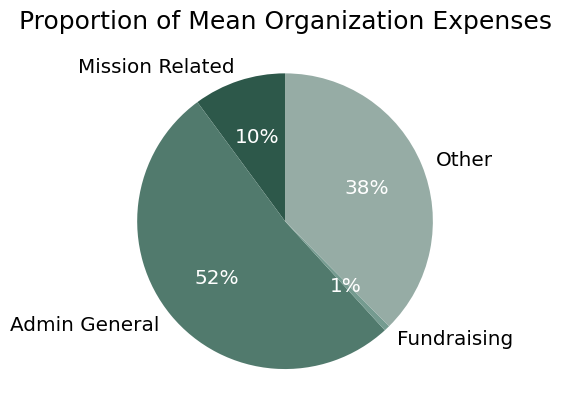

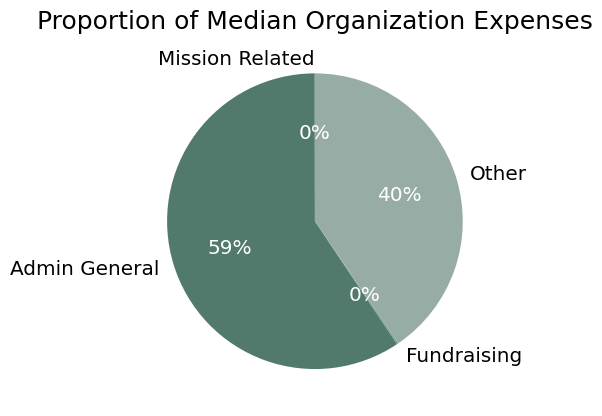

In [136]:
# Sum all fields that may add up to the Total functional expenses field (totfuncexpns)
columns_to_sum = df_expenses.columns.drop(['totfuncexpns','lessdirfndrsng'])
df_expenses.loc[:, 'sum_expenses'] = df_expenses[columns_to_sum].sum(axis=1) 

# Create cols by summing categorical expenses.
df_expenses.loc[:, 'mission_related'] = df_expenses[['grntstogovt','grnsttoindiv','grntstofrgngovt','converconventmtng']].sum(axis=1)
df_expenses.loc[:, 'admin_general'] = df_expenses[['compnsatncurrofcr','officexpns','insurance','occupancy','accntingfees','legalfees','feesforsrvcmgmt','feesforsrvcinvstmgmt','othrsalwages','payrolltx','pensionplancontrb','othremplyeebenef','infotech','compnsatnandothr','travelofpublicoffcl','benifitsmembrs']].sum(axis=1)
df_expenses.loc[:, 'fundraising'] = df_expenses[['profndraising','advrtpromo','lessdirfndrsng']].sum(axis=1)
df_expenses.loc[:, 'other'] = df_expenses[['deprcatndepletn','feesforsrvclobby','pymtoaffiliates','royaltsexpns','travel','infotech','othrexpnsa','othrexpnsb','othrexpnsc','othrexpnsd','othrexpnse','othrexpnsf','feesforsrvcothr']].sum(axis=1)

# What % of sum_expenses = to total expenses
equal_rows = (df_expenses['totfuncexpns'] == df_expenses['sum_expenses']).sum()
total_rows = df_expenses.shape[0]
percentage = round((equal_rows / total_rows) * 100)
#print(f"Percentage of rows where 'totfuncexpns' equals self calculated total expenses: {percentage}%")

#  mean values
mean_mission_exp = df_expenses['mission_related'].mean()
mean_admin_exp = df_expenses['admin_general'].mean()
mean_fundraising_exp = df_expenses['fundraising'].mean()
mean_other_exp = df_expenses['other'].mean()

med_mission_exp = df_expenses['mission_related'].median()
med_admin_exp = df_expenses['admin_general'].median()
med_fundraising_exp = df_expenses['fundraising'].median()
med_other_exp = df_expenses['other'].median()

colors = ['#2D584A', '#517A6D', '#759B90', '#96ACA5'] 

# Create the pie chart
def pie_chart(sizes, labels, statistic):
    fig, ax = plt.subplots()
    wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.0f%%',
                                    startangle=90, colors=colors, textprops={'size': 'x-large'})
    plt.setp(autotexts, color='white', size='x-large')
    plt.title(f'Proportion of {statistic} Organization Expenses',fontsize=18)
    plt.show()

sizes = [mean_mission_exp, mean_admin_exp, mean_fundraising_exp, mean_other_exp]
labels = ['Mission Related', 'Admin General', 'Fundraising', 'Other']
pie_chart(sizes, labels, 'Mean')

sizes = [med_mission_exp, med_admin_exp, med_fundraising_exp, med_other_exp]
labels = ['Mission Related', 'Admin General', 'Fundraising', 'Other']
pie_chart(sizes, labels, 'Median')

## 3. What subsection of Admin is so costly? 

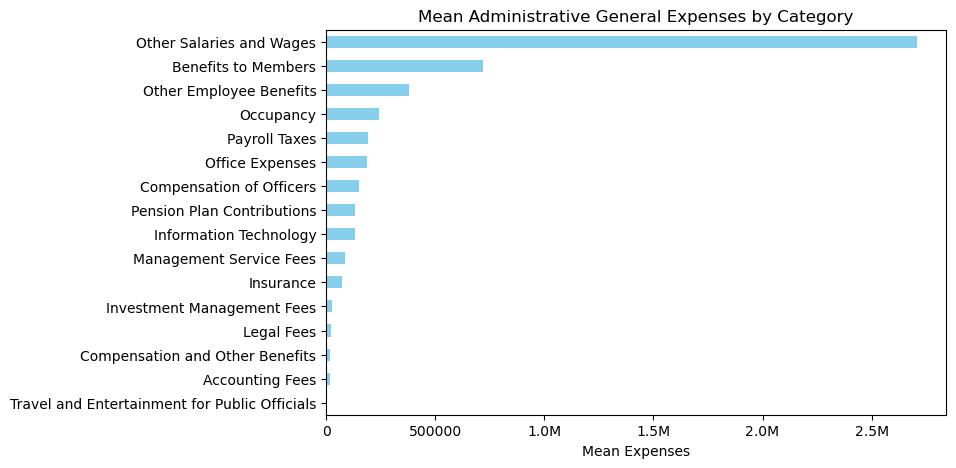

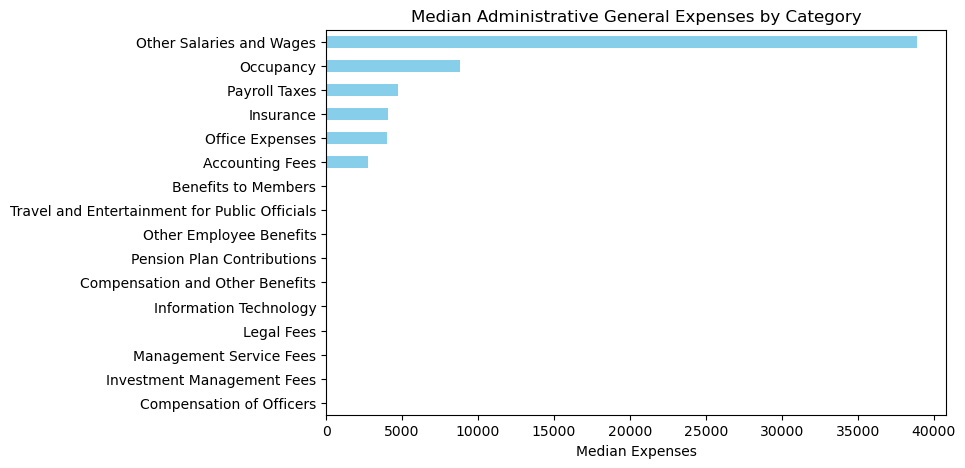

In [171]:
column_names = {
    'compnsatncurrofcr': 'Compensation of Officers',
    'officexpns': 'Office Expenses',
    'insurance': 'Insurance',
    'occupancy': 'Occupancy',
    'accntingfees': 'Accounting Fees',
    'legalfees': 'Legal Fees',
    'feesforsrvcmgmt': 'Management Service Fees',
    'feesforsrvcinvstmgmt': 'Investment Management Fees',
    'othrsalwages': 'Other Salaries and Wages',
    'payrolltx': 'Payroll Taxes',
    'pensionplancontrb': 'Pension Plan Contributions',
    'othremplyeebenef': 'Other Employee Benefits',
    'infotech': 'Information Technology',
    'compnsatnandothr': 'Compensation and Other Benefits',
    'travelofpublicoffcl': 'Travel and Entertainment for Public Officials',
    'benifitsmembrs': 'Benefits to Members'
}

df_expenses.rename(columns=column_names, inplace=True)

mean_admin_exp = df_expenses[list(column_names.values())].mean()
med_admin_exp = df_expenses[list(column_names.values())].median()

from matplotlib.ticker import FuncFormatter
def millions_formatter(x, pos):
    if x >= 1e9:  # For values in billions
        return f'{x * 1e-9:.1f}B'
    elif x >= 1e6:  # For values in millions
        return f'{x * 1e-6:.1f}M'
    else:
        return int(x)

plt.figure(figsize=(8, 5))
ax = mean_admin_exp.sort_values().plot(kind='barh', color='skyblue')
plt.xlabel('Mean Expenses')
plt.title('Mean Administrative General Expenses by Category')
ax.xaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.show()

plt.figure(figsize=(8, 5))
ax = med_admin_exp.sort_values().plot(kind='barh', color='skyblue')
plt.xlabel('Median Expenses')
plt.title('Median Administrative General Expenses by Category')
ax.xaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.show()


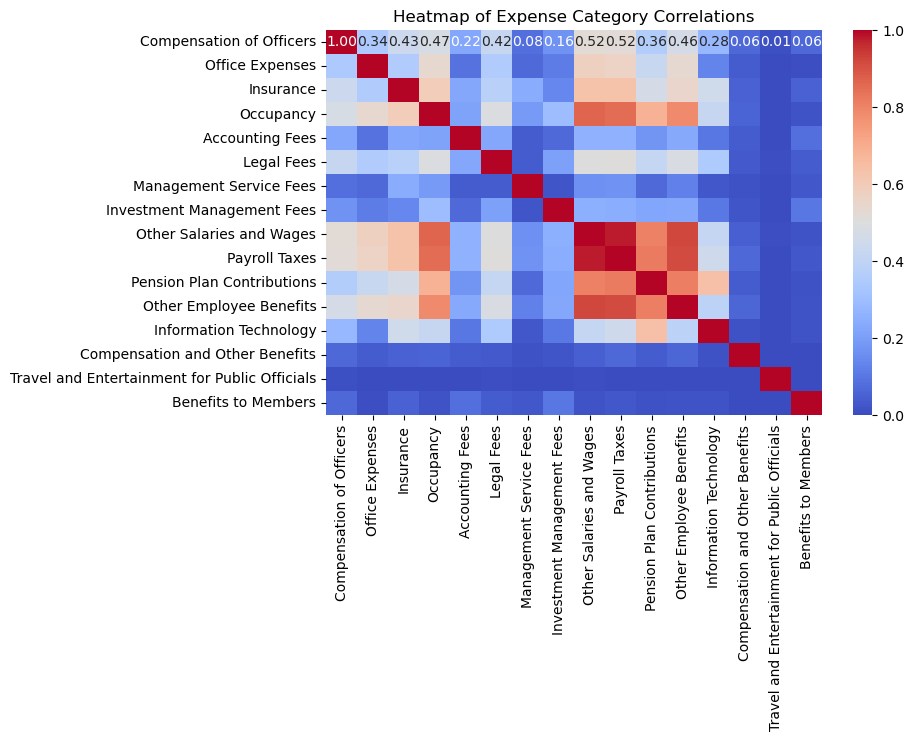

In [165]:
corr_matrix = df_expenses[list(column_names.values())].corr()
plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Heatmap of Expense Category Correlations')
plt.show()


## 4. What is the mean/median total revenue for tax exempt orgs? 

In [137]:
pd.options.mode.chained_assignment = None  # Disable the SettingWithCopyWarning

# Filter dataset to section IX fields from Form 990.
df_revenue = df[['totrevenue','totprgmrevnue','miscrevtot11e','totcntrbgfts']] 

mean_revenue = round(df.totrevenue.mean())
formatted_mean_revenue = "{:,}".format(mean_revenue)
print(f"The average total revenue for the 2022 tax exempts is ${formatted_mean_revenue}")


The average total revenue for the 2022 tax exempts is $11,030,154


## 5. What is the mean/median percentage breakdown of revenue by category? 
* Vis note: think about a bar chart instead of pie chart


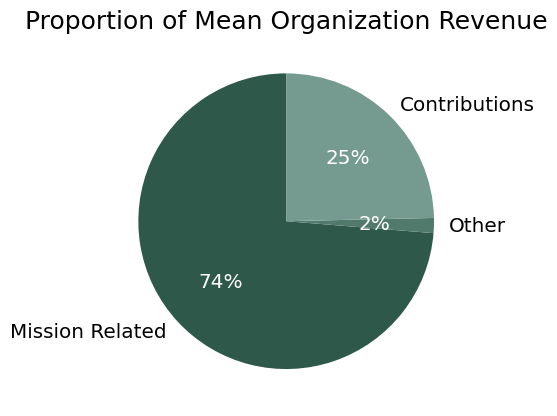

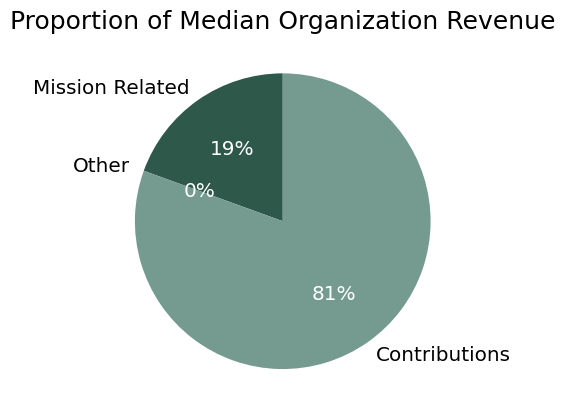

In [140]:
#  mean values
mean_program_rev = df_revenue['totprgmrevnue'].mean()
mean_other_rev = df_revenue['miscrevtot11e'].mean()
mean_contribution_rev = df_revenue['totcntrbgfts'].mean()

med_program_rev = df_revenue['totprgmrevnue'].median()
med_other_rev = df_revenue['miscrevtot11e'].median()
med_contribution_rev = df_revenue['totcntrbgfts'].median()

colors = ['#2D584A', '#517A6D', '#759B90', '#96ACA5'] 

# Create the pie chart
def pie_chart(sizes, labels, statistic):
    fig, ax = plt.subplots()
    wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.0f%%',
                                    startangle=90, colors=colors, textprops={'size': 'x-large'})
    plt.setp(autotexts, color='white', size='x-large')
    plt.title(f'Proportion of {statistic} Organization Revenue',fontsize=18)
    plt.show()

sizes = [mean_program_rev, mean_other_rev, mean_contribution_rev]
labels = ['Mission Related', 'Other', 'Contributions']
pie_chart(sizes, labels, 'Mean')

sizes = [med_program_rev, med_other_rev, med_contribution_rev]
labels = ['Mission Related', 'Other', 'Contributions']
pie_chart(sizes, labels, 'Median')

## Is there a statistically significant differences in spending patterns among categories or locations? ANOVA 
## What types of factors influence more spending in mission related outcomes? Linear Reg or Log Reg
## Cluster analysis of spending patterns

# Impact

## 1. What proportion of nonprofits engage in grantmaking?

In [143]:
df_grants_binary = df[['rptgrntstoindvcd','rptgrntstogovtcd']]

df_grants_binary = df_grants_binary[(df_grants_binary['rptgrntstoindvcd']=='Y') | (df_grants_binary['rptgrntstogovtcd']=='Y')]
orgs_that_grant = df_grants_binary.value_counts().sum()
total_orgs = df.shape[0]
proportion = round((orgs_that_grant / total_orgs)*100)
print(f"{proportion}% of nonprofits engage in grantmaking")

21% of nonprofits engage in grantmaking


## 2. What are organization's patterns of distribution for grants to individuals vs other orgs?

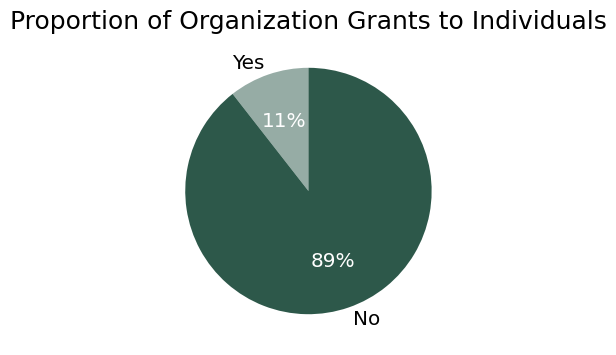

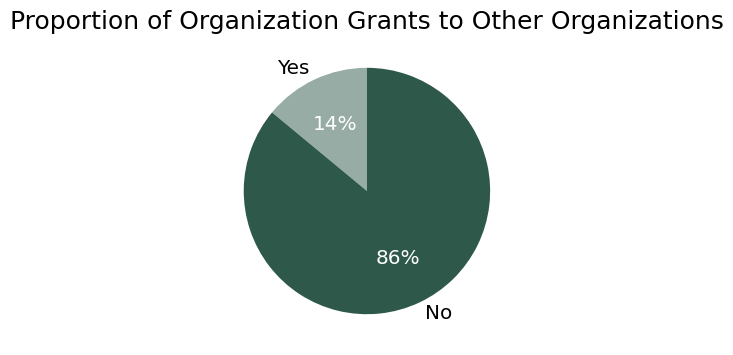

In [8]:
in_grants_ct = df['rptgrntstoindvcd'].value_counts()

Individuals = df['rptgrntstoindvcd'].value_counts().loc[['Y', 'N']]
Organizations = df['rptgrntstogovtcd'].value_counts().loc[['Y', 'N']]

custom_labels = ['Yes', 'No']
labels_ordered = [custom_labels[i] for i in range(len(in_grants_ct))]

pichart_dfs = [Individuals, Organizations]
labels = ['Grants to Individuals', 'Grants to Other Organizations']

for data, label in zip(pichart_dfs, labels):
    plt.figure(figsize=(6, 4))
    _, _, autotexts = plt.pie(data, labels=custom_labels, autopct='%1.0f%%', startangle=90, colors=['#96ACA5', '#2D584A'], textprops={'size': 'x-large'})
    for ins in autotexts:
        ins.set_color('white')
    plt.title(f'Proportion of Organization {label}', fontsize=18)
    plt.show()

## 3. What is the dollar distribution of grants to individuals vs organizations?

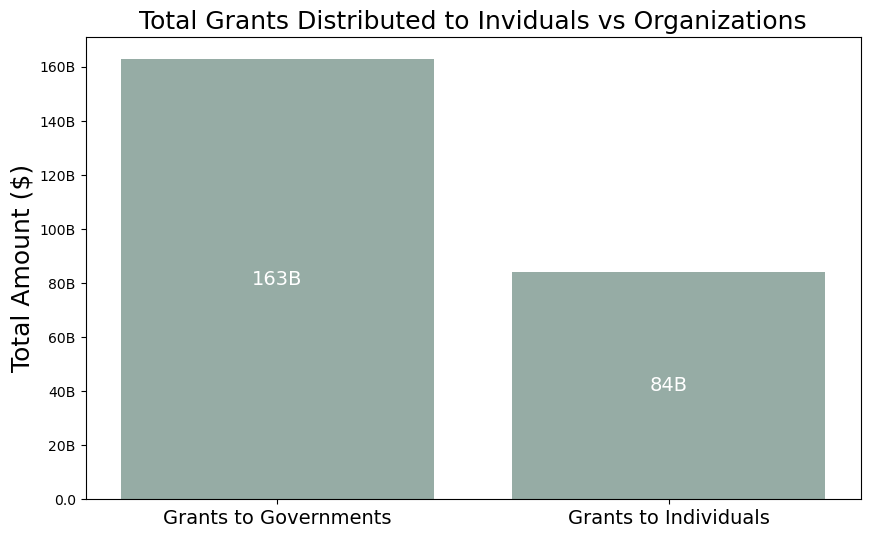

In [155]:
# Create function for abreviated value labels.
from matplotlib.ticker import FuncFormatter

def human_readable(x, pos):
    if x >= 1e12:  # Trillions
        s = f'{x / 1e12:.0f}T'
    elif x >= 1e9:  # Billions
        s = f'{x / 1e9:.0f}B'
    elif x >= 1e6:  # Millions
        s = f'{x / 1e6:.0f}M'
    elif x >= 1e3:  # Thousands
        s = f'{x / 1e3:.0f}K'
    else:
        s = str(x)
    return s
formatter = FuncFormatter(human_readable)

categories = ['Grants to Governments', 'Grants to Individuals']
values = [df['grntstogovt'].sum(), df['grnsttoindiv'].sum()]

plt.figure(figsize=(10, 6))
bars = plt.bar(categories, values, color='#96ACA5')

for bar in bars:
    yval = bar.get_height()  # Get the height of the bar
    plt.text(bar.get_x() + bar.get_width()/2, yval/2, f'{human_readable(yval, None)}',  # Use human_readable for label
             ha='center', va='center', color='white', fontsize=14)

plt.title('Total Grants Distributed to Inviduals vs Organizations',fontsize=18)
plt.ylabel('Total Amount ($)',fontsize=18)
plt.xticks(fontsize=14)
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

## 4. What does the geogrphical reach (national vs international) look like for grant giving? 

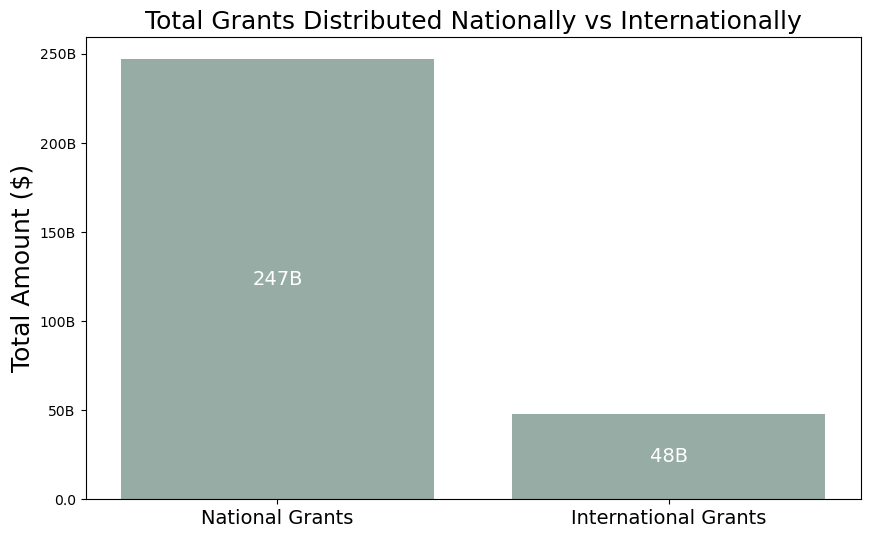

In [156]:

# Create function for abreviated value labels.
from matplotlib.ticker import FuncFormatter

def human_readable(x, pos):
    if x >= 1e12:  # Trillions
        s = f'{x / 1e12:.0f}T'
    elif x >= 1e9:  # Billions
        s = f'{x / 1e9:.0f}B'
    elif x >= 1e6:  # Millions
        s = f'{x / 1e6:.0f}M'
    elif x >= 1e3:  # Thousands
        s = f'{x / 1e3:.0f}K'
    else:
        s = str(x)
    return s
formatter = FuncFormatter(human_readable)

categories = ['National Grants', 'International Grants']
values = [df['grntstogovt'].sum() + df['grnsttoindiv'].sum(), df['grntstofrgngovt'].sum()]

plt.figure(figsize=(10, 6))
bars = plt.bar(categories, values, color='#96ACA5')

for bar in bars:
    yval = bar.get_height()  # Get the height of the bar
    plt.text(bar.get_x() + bar.get_width()/2, yval/2, f'{human_readable(yval, None)}',  # Use human_readable for label
             ha='center', va='center', color='white', fontsize=14)

plt.title('Total Grants Distributed Nationally vs Internationally',fontsize=18)
plt.ylabel('Total Amount ($)',fontsize=18)
plt.xticks(fontsize=14)
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()